In [1]:
%matplotlib inline

In [2]:
!pip install -U captum
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 29.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [3]:
import os, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import ray
import ray.cloudpickle as pickle
from ray import train,tune
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

### Assign base path and dataset variable

In [4]:
base_path = '/kaggle/input/deep-learning-for-msc-202324/'

### Custom Dataset Class



In [5]:
class ProteinDataset(Dataset):
    
    def __init__(self, seq_file, pssm_dir, label_file=None, is_train=True):
        self.sequences = pd.read_csv(seq_file)
        self.label_data = None
        if label_file:
            self.label_data = pd.read_csv(label_file)
        self.pssm_dir = pssm_dir
        self.is_train = is_train
        
    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq_id = self.sequences['PDB_ID'].iloc[idx]
        seq = self.sequences['SEQUENCE'].iloc[idx]
        
        if self.is_train:
            pssm_df = pd.read_csv(f"{self.pssm_dir}/{seq_id}_train.csv")
        else:
            pssm_df = pd.read_csv(f"{self.pssm_dir}/{seq_id}_test.csv")
        pssm_values = pssm_df.iloc[:, 2:].values
        pssm = torch.tensor(pssm_values, dtype=torch.float32)
        sample = {'seq': seq, 'pssm': pssm}

        if self.label_data is not None:
            labels = self.label_data[self.label_data['PDB_ID'] == seq_id]['SEC_STRUCT'].values[0]
            sample['labels'] = labels

        return sample

### FCN Model

In [6]:
class SecondaryStructureNNModel(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super(SecondaryStructureNNModel, self).__init__()
        self.conv1 = nn.Conv1d(20, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(256)
        self.final_conv = nn.Conv1d(256, 3, kernel_size=1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = nn.functional.relu(self.bn4(self.conv4(x)))
        x = self.dropout(x)
        x = self.final_conv(x)
        return nn.functional.log_softmax(x, dim=1)

### Helper Functions

* `encode_label`: This function takes a sequence label (e.g., a string representing secondary structure annotations) and converts it into a numerical format suitable for model training. It does this by mapping each character in the input label to a numeric value, according to a predefined `label_mapping` dictionary.
* `protein_collate_fn`: Used as a custom collate function for creating batches during training. It takes a list of samples, where each sample is a dictionary containing sequences, PSSM data, and labels. The function extracts these elements, pads the PSSM data and encoded labels to ensure consistent tensor shapes within a batch, and returns a dictionary with sequences, padded PSSMs, and padded labels. 
* `test_collate_fn`: Similar to `protein_collate_fn`, but tailored for test datasets where labels might not be available. It handles the padding of PSSM data for a consistent tensor shape across the test batch, returning a dictionary with sequences and padded PSSMs. This function facilitates batch processing during model evaluation or inference phases.
* `plot_metrics`: This function visualizes the training process's performance metrics, specifically validation loss and accuracy across epochs.

In [7]:
label_mapping = {'H': 0, 'E': 1, 'C': 2}
decode_mapping = {value: key for key, value in label_mapping.items()}


def encode_label(label):
    return [label_mapping[c] for c in label]

def protein_collate_fn(batch):
    seqs, pssms, labels = zip(*[(b['seq'], b['pssm'], b['labels']) for b in batch])
    
    pssms_padded = pad_sequence(pssms, batch_first=True)
    
    encoded_labels = [torch.tensor(encode_label(label), dtype=torch.long) for label in labels]
    labels_padded = pad_sequence(encoded_labels, batch_first=True)
    
    return {'seqs': seqs, 'pssms': pssms_padded, 'labels': labels_padded}

def test_collate_fn(batch):
    seqs, pssms = zip(*[(b['seq'], b['pssm']) for b in batch])
    
    pssms_padded = pad_sequence(pssms, batch_first=True)
    
    return {'seqs': seqs, 'pssms': pssms_padded}

def plot_metrics(validation_losses, validation_accuracies):
    epochs = range(1, len(validation_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, validation_losses, 'ro-', label='Validation Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, validation_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.suptitle("Best Trial Accuracy and Loss")
    plt.tight_layout()
    plt.show()

In [8]:
def train_model(config):
#     Initialise model and available device
    model = SecondaryStructureNNModel(config['dropout'])
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    
#     Initialise dataset and split into train and validation set
    dataset = ProteinDataset(base_path + 'seqs_train.csv', base_path + 'train', base_path + 'labels_train.csv')
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_set, validation_set = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True, collate_fn=protein_collate_fn)
    validation_loader = DataLoader(validation_set, batch_size=config['batch_size'], shuffle=True, collate_fn=protein_collate_fn)
    
    
    checkpoint = train.get_checkpoint()
    if checkpoint:
        with train.get_checkpoint().as_directory() as checkpoint_dir:
          with open(os.path.join(checkpoint_dir, 'data.pkl'), 'rb') as fp:
            checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state["epoch"]
            net.load_state_dict(checkpoint_state["net_state_dict"])
            optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0
        
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    
    for epoch in range(100):
#         Training loop
        model.train()
        for batch in train_loader:
            sequences, pssms, labels = batch['seqs'], batch['pssms'].to(device), batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(pssms.transpose(1, 2))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
#         Evaluation Loop
        model.eval()
        val_loss = 0.0
        total_correct = 0
        total_elements = 0
        with torch.no_grad():
            for batch in validation_loader:
                sequences, pssms, labels = batch['seqs'], batch['pssms'].to(device), batch['labels'].to(device)
                outputs = model(pssms.transpose(1, 2))
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total_correct += (predicted == labels).sum().item()
                total_elements += labels.nelement()
        
        val_loss /= len(validation_loader)
        accuracy = total_correct / total_elements
        
#         Save checkpoint
        checkpoint_data = {
            "epoch": epoch,
            "net_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        
        with tempfile.TemporaryDirectory() as checkpoint_dir:
          with open(os.path.join(checkpoint_dir, 'data.pkl'), 'wb') as fp:
            pickle.dump(checkpoint_data, fp)

          checkpoint = Checkpoint.from_directory(checkpoint_dir)

          train.report(
              {"loss": val_loss, "accuracy": accuracy},
              checkpoint=checkpoint,
          )

In [9]:
config = {
    "dropout": tune.loguniform(0.2, 0.4),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([16, 32, 64]),
}

scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=100,
        grace_period=1,
        reduction_factor=2,
)

result = tune.run(
        train_model,
        resources_per_trial={"cpu": 4, "gpu": 0},
        config=config,
        num_samples=10,
        scheduler=scheduler,
)

best_trial = result.get_best_trial("loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

2024-03-02 12:29:35,362	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2024-03-02 12:29:36,998	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-03-02 12:29:37,005	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,accuracy,loss,should_checkpoint
train_model_886cc_00000,0.934305,0.170096,True
train_model_886cc_00001,0.909899,0.235119,True
train_model_886cc_00002,0.914042,0.22936,True
train_model_886cc_00003,0.909665,0.232968,True
train_model_886cc_00004,0.927565,0.190289,True
train_model_886cc_00005,0.9441,0.14076,True
train_model_886cc_00006,0.894988,0.266484,True
train_model_886cc_00007,0.918039,0.20728,True
train_model_886cc_00008,0.911094,0.233383,True
train_model_886cc_00009,0.898601,0.260374,True


(train_model pid=377) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_2024-03-02_12-29-37/train_model_886cc_00000_0_batch_size=32,dropout=0.2496,lr=0.0132_2024-03-02_12-29-48/checkpoint_000000)
(train_model pid=377) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_2024-03-02_12-29-37/train_model_886cc_00000_0_batch_size=32,dropout=0.2496,lr=0.0132_2024-03-02_12-29-48/checkpoint_000001)
(train_model pid=377) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_2024-03-02_12-29-37/train_model_886cc_00000_0_batch_size=32,dropout=0.2496,lr=0.0132_2024-03-02_12-29-48/checkpoint_000002)
(train_model pid=377) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_2024-03-02_12-29-37/train_model_886cc_00000_0_batch_size=32,dropout=0.2496,lr=0.0132_2024-03-02_12-29-48/checkpoint_000003)
(train_model pid

Best trial config: {'dropout': 0.2711959364624338, 'lr': 0.000934912277705373, 'batch_size': 64}
Best trial final validation loss: 0.14076034400774085
Best trial final validation accuracy: 0.9440997489774996


In [10]:
model = SecondaryStructureNNModel(best_trial.config['dropout'])
best_checkpoint = best_trial.checkpoint;

### Interpreting Model Performance

**Visualising Validation Loss and Accuracy**

Validation Loss and Accuracy seems normal since the loss decrease as the epoch is increasing. While accuracy improve when epoch is increase.

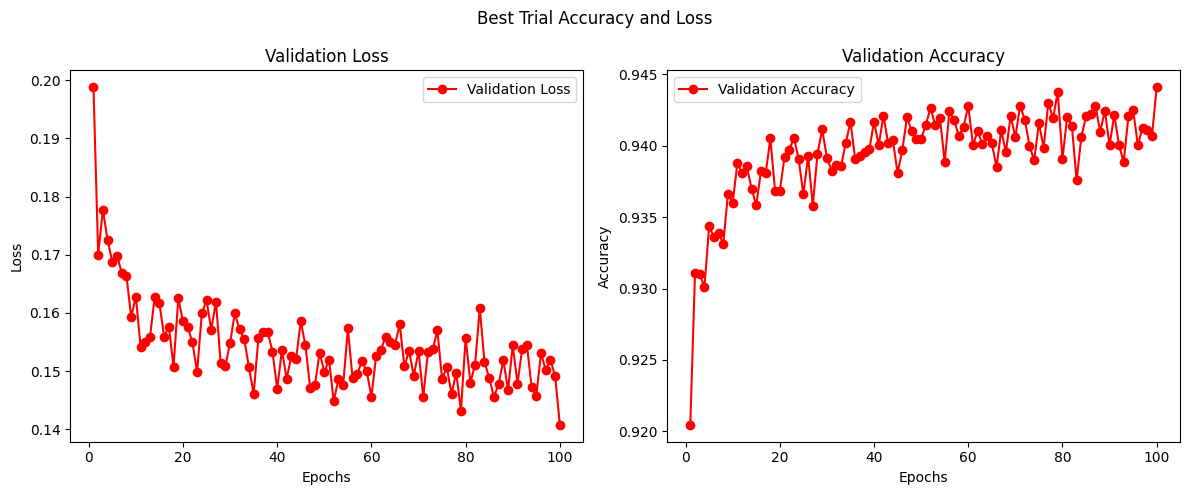

In [11]:
best_trail_results_df = result.trial_dataframes[best_trial.trial_id]
accuracies = best_trail_results_df.accuracy.to_list()
losses = best_trail_results_df.loss.to_list()
plot_metrics(losses, accuracies)

**Visualising Feature Importance Over the Output Classes**



In [12]:
# Custom forward function to transform the output for IntegratedGradients
def captum_forward(inputs, class_index):
    outputs = model(inputs.transpose(1, 2))
    selected_outputs = outputs[:, class_index, :].unsqueeze(-1)
    return selected_outputs

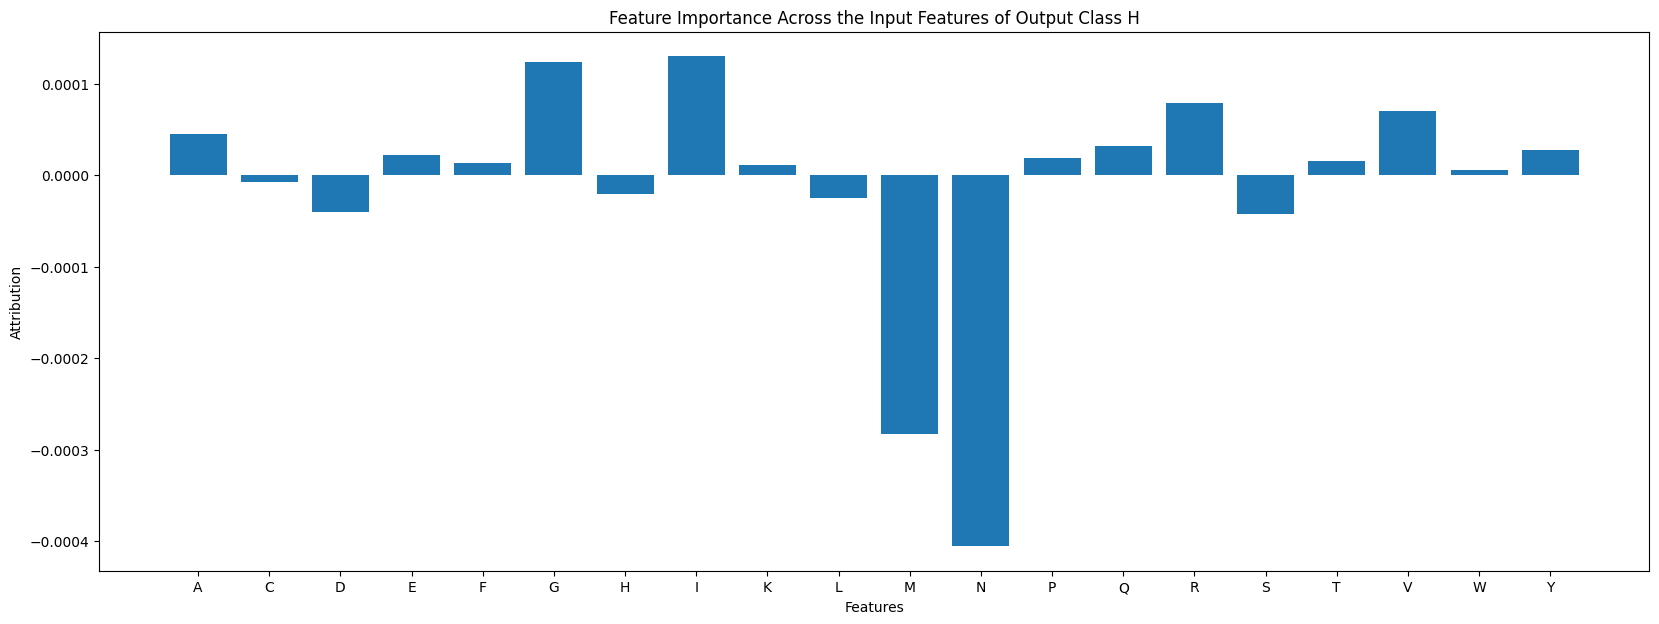

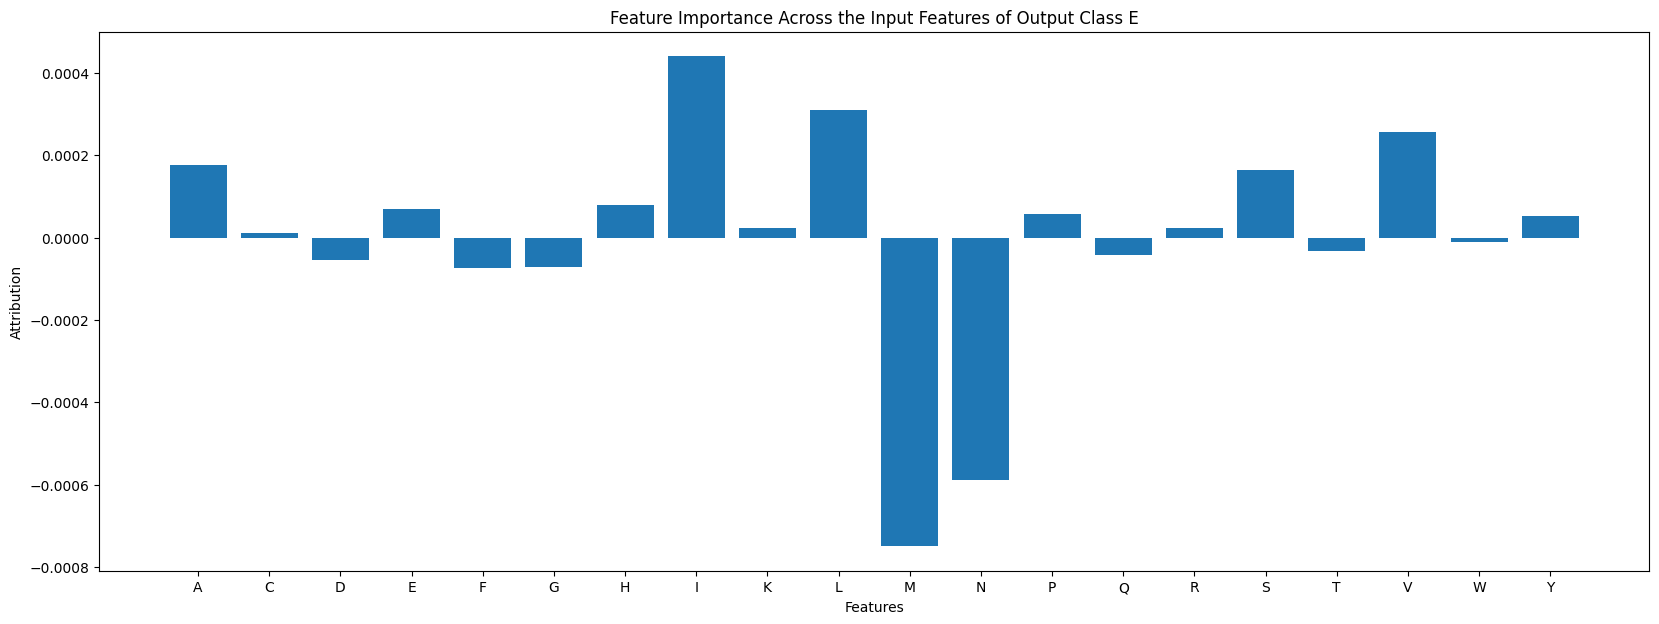

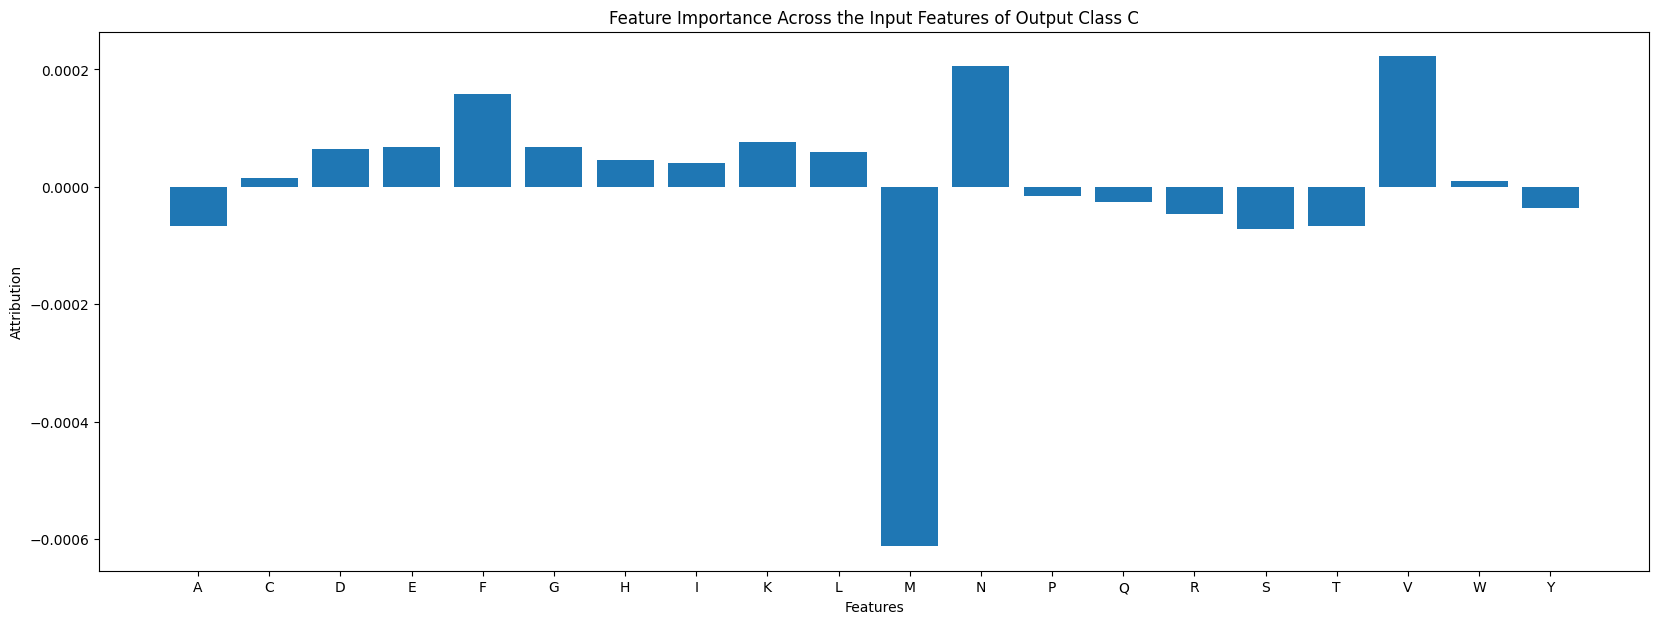

In [13]:
dataset = ProteinDataset(base_path + 'seqs_train.csv', base_path + 'train', base_path + 'labels_train.csv')
data_loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=protein_collate_fn)

batch = next(iter(data_loader))
inputs, labels = batch['pssms'], batch['labels']
inputs.requires_grad = True

for class_index in range(3):
    ig = IntegratedGradients(lambda inputs: captum_forward(inputs, class_index))

    attr, delta = ig.attribute(inputs=inputs, target=class_index, return_convergence_delta=True)
    attr = attr.detach().numpy()

    features = list(set(batch['seqs'][0]))
    features = sorted(features)
    importances = np.mean(attr[0], axis=0)
    
#     Visualise Feature Importance
    plt.figure(figsize=(20, 7))
    plt.bar(features, importances, label='Feature Importance')
    plt.ylabel('Attribution')
    plt.xlabel('Features')
    plt.title(f'Feature Importance Across the Input Features of Output Class {decode_mapping[class_index]}')
    plt.show()

### Prediction

In [14]:
def predict_test(model):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dataset = ProteinDataset(base_path + 'seqs_test.csv', base_path + 'test', is_train=False)

    testloader = torch.utils.data.DataLoader(
        dataset, batch_size=16, shuffle=False, collate_fn=test_collate_fn
    )
    
    predictions = []
    with torch.no_grad():
        for batch in testloader:
            sequences, pssms = batch['seqs'], batch['pssms'].to(device)
            
            outputs = model(pssms.transpose(1, 2))
            _, predicted = torch.max(outputs.data, 1)
            
            decoded_predictions = []
            for actual_sequence, predicted_sequence in zip(sequences, predicted):
                decoded_sequence = [decode_mapping[label.item()] for label in predicted_sequence]
                decoded_predictions.append(decoded_sequence[:len(actual_sequence)])
            predictions.extend(decoded_predictions)
    
    return predictions

In [15]:
if best_checkpoint:
    with best_checkpoint.as_directory() as checkpoint_dir:
      with open(os.path.join(checkpoint_dir, 'data.pkl'), 'rb') as fp:
        best_checkpoint_data = pickle.load(fp)
        model.load_state_dict(best_checkpoint_data["net_state_dict"])
        
#         Creating a submission file
        submission_df = pd.read_csv(base_path+'seqs_test.csv')
        submission_df['STRUCTURE'] = predict_test(model)
        submission_df.drop('SEQUENCE', inplace=True, axis=1)
        submission_df.rename(columns={'PDB_ID': 'ID'}, inplace=True)

        expanded_data = []
        for _, row in submission_df.iterrows():
            pdb_id = row['ID']
            structures = row['STRUCTURE']

            # Expand the current row into multiple rows, one per structure
            for index, structure in enumerate(structures, start=1):
                expanded_data.append((f"{pdb_id}_{index}", structure))

        submission_df = pd.DataFrame(expanded_data, columns=['ID', 'STRUCTURE'])
        submission_df.to_csv('/kaggle/working/submission.csv', index=False)